<a href="https://colab.research.google.com/github/SasiwimonV/bsc_dpdm22/blob/main/Midterm_dpdm22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## การเตรียมข้อมูลประกอบด้วย กำจัด outlier, แก้ missing, normalization, one-hot-encoder และ อื่นๆ ที่นักศึกษาเห็นว่าเหมาะสม

###Import Data 
- Google sheets
- json file 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import auth #เชื่อม Colab กับ google sheet
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
import pandas as pd
#defining my worksheet
worksheethand1 = gc.open('Data House').get_worksheet(1) # import google sheet
worksheethand2 = gc.open('Data House').sheet1 # import google sheet
worksheet2 = gc.open('คำตอบนักประเมิน(ID)').sheet1 # import google sheet

rows = worksheethand2.get_all_values()
rows1 = worksheethand1.get_all_values()
rows2 = worksheet2.get_all_values()

#Convert to a DataFrame 
data_h1 = pd.DataFrame(rows1)  #data house
data_h2 = pd.DataFrame(rows)
data_id = pd.DataFrame(rows2) #data ID ผู้ประเมิน

In [ ]:
import json
with open('/content/drive/MyDrive/datamining/Midterm/7-eleven.json') as json_file1:
  json7 = json.loads(json_file1.read())
with open('/content/drive/MyDrive/datamining/Midterm/school.json') as json_file12:
  json_school = json.loads(json_file12.read())

In [ ]:
datarain = pd.read_excel('/content/drive/MyDrive/datamining/Midterm/DataRain.xlsx')
datarain.head()

,จังหวัด,วันที่,เดือนที่,ปีที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ,date
0,ขอนแก่น,1,10,2011,3.0,1005.47,27.6,9.0,24.2,83,1.4,9.0,2011-10-01
1,ขอนแก่น,2,10,2011,2.0,1006.65,25.6,10.0,24.0,92,17.7,10.0,2011-10-02
2,ขอนแก่น,3,10,2011,3.0,1007.49,25.6,10.0,22.9,86,3,10.0,2011-10-03
3,ขอนแก่น,4,10,2011,2.0,1008.28,25.8,8.0,21.9,80,0,8.0,2011-10-04
4,ขอนแก่น,5,10,2011,2.0,1009.88,24.3,10.0,21.7,86,2.2,10.0,2011-10-05


# 1 ทำนายราคาบ้าน 10 คะแนน
เตรียมข้อมูลเพื่อทำนายราคาบ้าน ราคาประเมินบ้าน และ คะแนนทรัพย์ จาก [google drive](https://drive.google.com/drive/folders/1uIcUFY1yldIq-A3wijh2n2N6az-EljIe?usp=sharing) โดยข้อมูลที่เตรียมต้องประกอบด้วย columns ต่อไปนี้

* ```'renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price'``` จากตาราง "คำตอบนักประเมิน(ID)"

* ```จำนวน 7-11 และ โรงเรียน ในรัศมี 200,500,1000,2000 เมตร (ตั้งชื่อ d200-7/11','d500-7/11',...,'d2000-7/11' แบะ ;d200-school','d500-school',...,'d2000-school')``` จากตาราง "7-eleven.json" และ "school.json"

* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากตาราง คำตอบนักประเมิน(ID) โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว

##**ตาราง คำตอบนักประเมิน ID , ต่อตาราง บ้านชีท1,2**

### Clean Data คำตอบนักประเมิน ID

In [ ]:
data_id = pd.DataFrame(rows2) #data ID ผู้ประเมิน

In [ ]:
data_id = data_id.rename(columns=data_id.iloc[0]) # row 0 = name -> change to name columns 
data_id = data_id.iloc[1:] # delete row 0 (old row is name)
data_id = data_id.reset_index() # increase columns ['index']
del data_id['index']


In [ ]:
data_id[['เหตุผลไม่มั่นใจราคาประเมิน']]

,เหตุผลไม่มั่นใจราคาประเมิน
0,
1,
2,
3,
4,
...,...
1912,
1913,
1914,
1915,


In [ ]:
data_id.isnull().values.any()

False

In [ ]:
data_id1 = data_id[data_id['ID ผู้ประเมิน']=='1']
data_id1 = data_id1[['ID', 'ID ผู้ประเมิน', 'ประเมินราคาซื้อ-ขาย','ให้คะแนนทรัพย์']]
data_id1.isnull().any()

ID                     False
ID ผู้ประเมิน          False
ประเมินราคาซื้อ-ขาย    False
ให้คะแนนทรัพย์         False
dtype: bool

### Clean Data บ้าน มือ 1, 2

In [ ]:
data_h1 = data_h1.rename(columns=data_h1.iloc[0]) # row 0 = name -> change to name columns 
data_h1 = data_h1.iloc[1:] # delete row 0 (old row is name)
data_h1 = data_h1.reset_index() # increase columns ['index']
del data_h1['index']


In [ ]:
data_h1.isnull().values.any()

False

In [ ]:
data_h1['renovate'] = 'no' # ไม่มี columns renovate เลยสร้าง แล้วเติม no ไว้ก่อน
data_h1['second_hand'] = 'บ้านมือ 1'

In [ ]:
data_h1['number_of_rai'] = 0 # ไม่มีรู้ข้อมูล columns เลยเติม no ไว้ก่อน
data_h1['number_of_ngan'] = 0 # ไม่มีรู้ข้อมูล columns เลยเติม no ไว้ก่อน

In [ ]:
datahome1 = data_h1[['id','renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price','second_hand']]
datahome1.head()

,id,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,314,no,0,0,50,2,4,3,0,0,185,2,3950000,บ้านมือ 1
1,315,no,0,0,40,2,4,3,0,0,165,2,3250000,บ้านมือ 1
2,316,no,0,0,77.25,2,4,3,0,0,260,2,6300000,บ้านมือ 1
3,317,no,0,0,81.25,2,6,5,0,0,343,3,6900000,บ้านมือ 1
4,318,no,0,0,55,2,4,4,0,0,223,2,4490000,บ้านมือ 1


In [ ]:
data_h1.columns # id, lat,  long

Index(['id', 'parent_id', 'project_name', 'province', 'district',
       'sub_district', 'zip_code', 'zone_id', 'zone', 'property_type',
       ...
       'cable_ask', 'position_previous', 'position_current', 'sold_out_at',
       'is_pro_in_house', 'created_at', 'updated_at', 'deleted_at', 'renovate',
       'second_hand'],
      dtype='object', length=143)

In [ ]:
data_h2 = data_h2.rename(columns=data_h2.iloc[0]) # row 0 = name -> change to name columns 
data_h2 = data_h2.iloc[1:] # delete row 0 (old row is name)
data_h2 = data_h2.reset_index() # increase columns ['index']
del data_h2['index']


In [ ]:
data_h2.isnull().values.any()

False

In [ ]:
data_h2['second_hand'] = 'บ้านมือ 2'

In [ ]:
datahome2 = data_h2[['id','renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price','second_hand']]
datahome2.head()

,id,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,1,no,0,1,45,2,2,2,ไม่ระบุ,ไม่มี,244,2,390000,บ้านมือ 2
1,4,no,0,0,88,1,1,1,ไม่ระบุ,ไม่มี,164,3,820000,บ้านมือ 2
2,16,no,1,0,8,1,11,11,ไม่ระบุ,ไม่ระบุ,489,9,3260000,บ้านมือ 2
3,18,no,0,0,61.6,2,3,3,ไม่ระบุ,ไม่ระบุ,203,2,5000000,บ้านมือ 2
4,19,no,0,0,72.3,2,3,2,ไม่ระบุ,ไม่ระบุ,164,2,3500000,บ้านมือ 2


### Json file

In [ ]:
seven_id = {}
for t in json7: # t = id
  l = list()
  for x in json7[t]:
    l.append(x['geometry'] ['location'])
    seven_id[t] = l

In [ ]:
school_id = {}
for t in json_school: # t = id
  l = list()
  for x in json_school[t]:
    l.append(x['geometry'] ['location'])
    school_id[t] = l

In [ ]:
school_id['1']

[{'lat': 16.1311875, 'lng': 102.6504375},
 {'lat': 16.1350641, 'lng': 102.6290474},
 {'lat': 16.1482073, 'lng': 102.6207588},
 {'lat': 16.1279195, 'lng': 102.6138295}]

## คอลัมน์ที่จะใช้คำนวณ
- seven_id
- data_h
- school_id

In [ ]:
import geopy.distance
import numpy as np


##บ้านมือ 1

###คำนวณ ระยะทาง เซเว่น กับ บ้านมือ 1

In [ ]:
record_list = []
for id in data_h1['id']: # Main loop วนซ้ำกับคอลัมน์ id ของ data_h1
    thishome1 = data_h1[data_h1['id']==id] #ตรวจสอบว่าค่า id ของ Main loop ตรงกับของ data_h1 ไหม
    h_lat = thishome1['latitude'].values[0]  
    h_lng = thishome1['longitude'].values[0]  
    this_seven = seven_id.get(id, []) # รับค่าของ id ใน dict seven_id หาก id ไม่มีใน dict จะส่งคืนรายการว่าง [] ตามค่าเริ่มต้น
    if this_seven:  # ถ้า this seven id ไม่ใช่ค่าว่าง จะรันโค๊ดคำนวณ ระยะทาง แล้วเพิ่มใน dict ไว้
        seven_dist=[] 
        loc1 = [h_lat,h_lng]
        for seven in this_seven: 
            loc2 = [seven['lat'],seven['lng']] 
            dist = geopy.distance.geodesic(loc1,loc2).m
            seven_dist.append(dist) 
        record_dict ={}
        record_dict['id'] = (id) 
        record_dict['d200-7/11'] = sum(np.array(seven_dist)<200)
        record_dict['d500-7/11'] = sum(np.array(seven_dist)<500)
        record_dict['d1000-7/11'] = sum(np.array(seven_dist)<1000)
        record_dict['d2000-7/11'] = sum(np.array(seven_dist)<2000)
    else: # แต่ถ้า this seven id เป็นค่าว่าง จะเติมระยะทางเป็น 0 แล้วเพิ่มใน dict ไว้
        record_dict ={}
        record_dict['id'] = (id)
        record_dict['d200-7/11'] = 0
        record_dict['d500-7/11'] = 0
        record_dict['d1000-7/11'] = 0
        record_dict['d2000-7/11'] = 0
    record_list.append(record_dict)

Home1_seven = pd.DataFrame(record_list)

In [ ]:
Home1_seven.head()

,id,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11
0,314,0,0,0,0
1,315,0,0,0,0
2,316,0,0,0,0
3,317,0,0,0,0
4,318,0,0,0,0


### คำนวณ ระยะทาง โรงเรียน กับ บ้านมือ 1

In [ ]:
len(school_id)

3500

In [ ]:
record1_list = list() #สร้าง list ว่างไว้รับข้อมูล
for id in data_h1['id']: # Main loop -> id วนลูป รับค่า ใน data_h columns id 
  if id in school_id: # ดูว่าถ้า id ที่ได้จากลูป ตรงกับ เซเว่นไหม 
    thishome1 = data_h1[data_h1['id']==id]  #thishome2 มีแค่ id ที่ตรงกัน กับของเซเว่นและบ้าน
    h_lat = thishome1['latitude'].values[0]  #กำหนดให้เอาแต่ค่า lat,lng ของบ้านหลังปัจจุบัน
    h_lng = thishome1['longitude'].values[0]  
    this_school = school_id.get(id, []) # รับค่าของ id ใน dict seven_id หาก id ไม่มีใน dict จะส่งคืนรายการว่าง [] ตามค่าเริ่มต้น
    school_dist=list() # list ของบ้านปัจจุบันกับเซเว่น
    loc1 = [h_lat,h_lng] #ละติจูดและลองจิจูดของบ้านปัจจุบัน ใช้เป็นตำแหน่ง เริ่มต้น ในการคำนวณระยะทาง
    for school in this_school: #loop ใน วนซ้ำรายการ 7-11 สำหรับบ้านปัจจุบัน
      loc2 = [school['lat'],school['lng']] #ละติจูดและลองจิจูดของร้าน 7-11 ในปัจจุบัน ซึ่งจะใช้เป็นตำแหน่ง สิ้นสุด ในการคำนวณระยะทาง
      dist = geopy.distance.geodesic(loc1,loc2).m
      school_dist.append(dist) 
   
    record_dict ={}#ส่วนนี้ของ loop นอก สร้าง dict 
    record_dict['id'] = (id) #เก็บค่า id จาก home['post_id']
    record_dict['d200-school'] = sum(np.array(school_dist)<200)
    record_dict['d500-school'] = sum(np.array(school_dist)<500)
    record_dict['d1000-school'] = sum(np.array(school_dist)<1000)
    record_dict['d2000-school'] = sum(np.array(school_dist)<2000)
    record1_list.append(record_dict)
  else: # แต่ถ้า this seven id เป็นค่าว่าง จะเติมระยะทางเป็น 0 แล้วเพิ่มใน dict ไว้
    record_dict ={}
    record_dict['id'] = (id)
    record_dict['d200-school'] = 0
    record_dict['d500-school'] = 0
    record_dict['d1000-school'] = 0
    record_dict['d2000-school'] = 0
    record1_list.append(record_dict)

Home1_school = pd.DataFrame(record1_list)

In [ ]:
Home1_school

,id,d200-school,d500-school,d1000-school,d2000-school
0,314,0,0,0,0
1,315,0,0,0,0
2,316,0,0,0,0
3,317,0,0,0,0
4,318,0,0,0,0
...,...,...,...,...,...
749,62204519412ede001495e6cb,0,0,0,0
750,62201e6fa441d30014e1f350,0,0,0,0
751,5fa0e476a3326800191e29ea,0,0,0,0
752,5e9d6fa69f161600121b61b2,0,0,0,0


In [ ]:
home1_dist = datahome1.merge(Home1_seven, left_on='id', right_on='id')
datahome1 = home1_dist.merge(Home1_school, left_on='id', right_on='id')


## บ้านมือ 2

###คำนวณ ระยะทาง เซเว่น กับ บ้านมือ 2

In [ ]:
record_list = list()  #สร้าง list ว่างไว้รับข้อมูล
for id in data_h2['id']:  # Main loop -> id วนลูป รับค่า ใน data_h columns id 
  if id in seven_id: # ดูว่าถ้า id ที่ได้จากลูป ตรงกับ เซเว่นไหม 
    thishome2 = data_h2[data_h2['id']==id]  #thishome2 มีแค่ id ที่ตรงกัน กับของเซเว่นและบ้าน
    h_lat = thishome2['latitude'].values[0]  #กำหนดให้เอาแต่ค่า lat,lng ของบ้านหลังปัจจุบัน
    h_lng = thishome2['longitude'].values[0]  
    this_seven = seven_id[id] #seven ที่ตรงกับ id บ้าน
    seven_dist=list()# list ของบ้านปัจจุบันกับเซเว่น
    loc1 = [h_lat,h_lng] ##ละติจูดและลองจิจูดของบ้านปัจจุบัน ใช้เป็นตำแหน่ง เริ่มต้น ในการคำนวณระยะทาง
    for seven in this_seven: #loop ใน วนซ้ำรายการ 7-11 สำหรับบ้านปัจจุบัน
      loc2 = [seven['lat'],seven['lng']] #ละติจูดและลองจิจูดของร้าน 7-11 ในปัจจุบัน ซึ่งจะใช้เป็นตำแหน่ง สิ้นสุด ในการคำนวณระยะทาง
      dist = geopy.distance.geodesic(loc1,loc2).m
      seven_dist.append(dist) 
   
    record_dict ={}#ส่วนนี้ของ loop นอก สร้าง dict 
    record_dict['id'] = (id) #เก็บค่า id จาก home['post_id']
    record_dict['d200-7/11'] = sum(np.array(seven_dist)<200)
    record_dict['d500-7/11'] = sum(np.array(seven_dist)<500)
    record_dict['d1000-7/11'] = sum(np.array(seven_dist)<1000)
    record_dict['d2000-7/11'] = sum(np.array(seven_dist)<2000)
    record_list.append(record_dict)

  else:
    record_dict ={}
    record_dict['id'] = (id)
    record_dict['d200-7/11'] = 0
    record_dict['d500-7/11'] = 0
    record_dict['d1000-7/11'] = 0
    record_dict['d2000-7/11'] = 0
    record_list.append(record_dict)

Home2_seven = pd.DataFrame(record_list)


In [ ]:
Home2_seven.head()

,id,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11
0,1,0,0,0,0
1,4,0,0,0,0
2,16,0,0,1,2
3,18,0,0,0,4
4,19,0,0,1,4


### คำนวณ ระยะทาง โรงเรียน กับ บ้าน

In [ ]:
record1_list = list() #สร้าง list ว่างไว้รับข้อมูล
for id in data_h2['id']: # Main loop -> id วนลูป รับค่า ใน data_h columns id 
  if id in school_id: # ดูว่าถ้า id ที่ได้จากลูป ตรงกับ เซเว่นไหม 
    thishome2 = data_h2[data_h2['id']==id]  #thishome2 มีแค่ id ที่ตรงกัน กับของเซเว่นและบ้าน
    h_lat = thishome2['latitude'].values[0]  #กำหนดให้เอาแต่ค่า lat,lng ของบ้านหลังปัจจุบัน
    h_lng = thishome2['longitude'].values[0]  
    this_school = school_id[id] #seven ที่ตรงกับ id บ้าน
    school_dist=list() # list ของบ้านปัจจุบันกับเซเว่น
    loc1 = [h_lat,h_lng] #ละติจูดและลองจิจูดของบ้านปัจจุบัน ใช้เป็นตำแหน่ง เริ่มต้น ในการคำนวณระยะทาง
    for school in this_school: #loop ใน วนซ้ำรายการ 7-11 สำหรับบ้านปัจจุบัน
      loc2 = [school['lat'],school['lng']] #ละติจูดและลองจิจูดของร้าน 7-11 ในปัจจุบัน ซึ่งจะใช้เป็นตำแหน่ง สิ้นสุด ในการคำนวณระยะทาง
      dist = geopy.distance.geodesic(loc1,loc2).m
      school_dist.append(dist) 
   
    record_dict ={}#ส่วนนี้ของ loop นอก สร้าง dict 
    record_dict['id'] = (id) #เก็บค่า id จาก home['post_id']
    record_dict['d200-school'] = sum(np.array(school_dist)<200)
    record_dict['d500-school'] = sum(np.array(school_dist)<500)
    record_dict['d1000-school'] = sum(np.array(school_dist)<1000)
    record_dict['d2000-school'] = sum(np.array(school_dist)<2000)
    record1_list.append(record_dict)
  else:
    record_dict ={}
    record_dict['id'] = (id)
    record_dict['d200-7/11'] = 0
    record_dict['d500-7/11'] = 0
    record_dict['d1000-7/11'] = 0
    record_dict['d2000-7/11'] = 0
    record_list.append(record_dict)
Home2_school = pd.DataFrame(record1_list)


In [ ]:
Home2_seven.shape #(1195, 5)

(1656, 5)

In [ ]:
Home2_school.shape #(1472, 5)

(1472, 5)

In [ ]:
datahome2.columns

Index(['id', 'renovate', 'number_of_rai', 'number_of_ngan', 'number_of_va',
       'number_of_story', 'number_of_bedroom', 'number_of_bathroom',
       'direction', 'furniture', 'usable_area', 'number_of_parking',
       'sell_price', 'second_hand'],
      dtype='object')

In [ ]:
Home2_dist = Home2_seven.merge(Home2_school, left_on='id', right_on='id')
datahome2 = datahome2.merge(Home2_dist, left_on='id', right_on='id')


## รวมตาราง Concat 

In [ ]:
datahome1 = datahome1.reset_index(drop=True)

In [ ]:
datahome2 = datahome2.reset_index(drop=True)

In [ ]:
frame = [datahome1, datahome2]
Data = pd.concat(frame)
Data.head() #ยังไม่่ลบคอลัมน์ id

,id,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,...,sell_price,second_hand,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school
0,314,no,0,0,50,2,4,3,0,0,...,3950000,บ้านมือ 1,0,0,0,0,0,0,0,0
1,315,no,0,0,40,2,4,3,0,0,...,3250000,บ้านมือ 1,0,0,0,0,0,0,0,0
2,316,no,0,0,77.25,2,4,3,0,0,...,6300000,บ้านมือ 1,0,0,0,0,0,0,0,0
3,317,no,0,0,81.25,2,6,5,0,0,...,6900000,บ้านมือ 1,0,0,0,0,0,0,0,0
4,318,no,0,0,55,2,4,4,0,0,...,4490000,บ้านมือ 1,0,0,0,0,0,0,0,0


In [ ]:
data_id1.isnull().any()

ID                     False
ID ผู้ประเมิน          False
ประเมินราคาซื้อ-ขาย    False
ให้คะแนนทรัพย์         False
dtype: bool

In [ ]:
Datatable = Data.merge(data_id1, left_on='id', right_on='ID')  
Datatable.isnull().values.any()

False

In [ ]:
del Datatable['id']
del Datatable['ID']

###Final table ข้อ 1


In [ ]:
Datatable.columns

Index(['renovate', 'number_of_rai', 'number_of_ngan', 'number_of_va',
       'number_of_story', 'number_of_bedroom', 'number_of_bathroom',
       'direction', 'furniture', 'usable_area', 'number_of_parking',
       'sell_price', 'second_hand', 'd200-7/11', 'd500-7/11', 'd1000-7/11',
       'd2000-7/11', 'd200-school', 'd500-school', 'd1000-school',
       'd2000-school', 'ID ผู้ประเมิน', 'ประเมินราคาซื้อ-ขาย',
       'ให้คะแนนทรัพย์'],
      dtype='object')

In [ ]:
Datatable.head() #1090 rows × 24 columns

,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,...,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school,ID ผู้ประเมิน,ประเมินราคาซื้อ-ขาย,ให้คะแนนทรัพย์
0,no,0,1,45,2,2,2,ไม่ระบุ,ไม่มี,244,...,0,0,0,0,0,1,2,1,"600,000",4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน
1,no,0,0,88,1,1,1,ไม่ระบุ,ไม่มี,164,...,0,0,0,0,1,1,4,1,"750,000",3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
2,no,1,0,8,1,11,11,ไม่ระบุ,ไม่ระบุ,489,...,0,1,2,0,0,5,13,1,"2,800,000",2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
3,no,0,0,61.6,2,3,3,ไม่ระบุ,ไม่ระบุ,203,...,0,0,4,0,0,1,8,1,"4,500,000",2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
4,no,0,1,0,2,7,3,ไม่ระบุ,ไม่ระบุ,383,...,1,3,11,0,1,4,10,1,"5,000,000",2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


# 2 ทำนายสภาพอากาศ 10 คะแนน
เตรียมข้อมูลเพื่อทำนายสภาพอากาศของวันถัดไป โดย 
- กลุ่มที่ 1 และ 9 ทำนาย อุณหภูมิตุ้มแห้ง (Y)
- กลุ่มที่ 2 ทำนาย อุณหภูมิต่ำสุด (Y)
- กลุ่มที่ 3 ทำนาย อุณหภูมิจุดน้ำค้าง (Y)
- กลุ่มที่ 4 ทำนาย จำนวนเมฆ (Y)
- กลุ่มที่ 5 ทำนาย ปริมาณฝน (Y)
- กลุ่มที่ 6 ทำนาย ความชื้นสัมพัทธ์ (Y)
- กลุ่มที่ 7 ทำนาย ความกด (Y)
- กลุ่มที่ 8 ทำนาย ความเร็วลม (Y)

ลักษณะของ data เป็นดังนี้ Xi คือ features อื่นๆที่ใช้ในทำนาย และ Y คือค่าที่ต้องการทำนาย

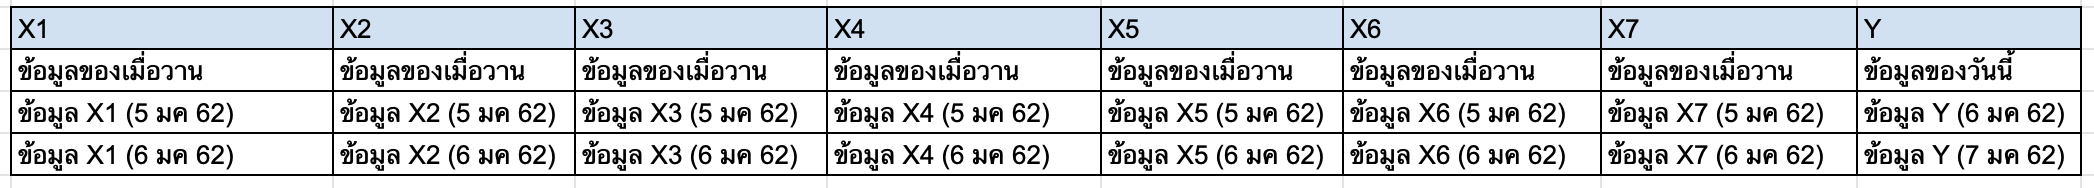



In [ ]:
datarain = pd.read_excel('/content/drive/MyDrive/datamining/Midterm/DataRain.xlsx')
datarain.head()

,จังหวัด,วันที่,เดือนที่,ปีที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ,date
0,ขอนแก่น,1,10,2011,3.0,1005.47,27.6,9.0,24.2,83,1.4,9.0,2011-10-01
1,ขอนแก่น,2,10,2011,2.0,1006.65,25.6,10.0,24.0,92,17.7,10.0,2011-10-02
2,ขอนแก่น,3,10,2011,3.0,1007.49,25.6,10.0,22.9,86,3,10.0,2011-10-03
3,ขอนแก่น,4,10,2011,2.0,1008.28,25.8,8.0,21.9,80,0,8.0,2011-10-04
4,ขอนแก่น,5,10,2011,2.0,1009.88,24.3,10.0,21.7,86,2.2,10.0,2011-10-05


###Clean Data

In [ ]:
del datarain['จังหวัด']
del datarain['เดือนที่']
del datarain['ปีที่']
del datarain['date']

### แก้ missing Data

In [ ]:
datarain.dtypes

วันที่                  int64
ความเร็วลม            float64
ความกด                float64
อุณหภูมิตุ้ม          float64
อุณหภูมิจุดน้ำค้าง    float64
อุณหภูมิจุดต่ำสุด     float64
ความชื้น                int64
ปริมาณฝน               object
ปริมาณเมฆ             float64
dtype: object

In [ ]:
datarain.isnull().any()

วันที่                False
ความเร็วลม             True
ความกด                False
อุณหภูมิตุ้ม          False
อุณหภูมิจุดน้ำค้าง     True
อุณหภูมิจุดต่ำสุด     False
ความชื้น              False
ปริมาณฝน              False
ปริมาณเมฆ              True
dtype: bool

In [ ]:
missing = datarain[datarain.isnull().any(axis=1)] # Show ความเร็วลม ,อุณหภูมิน้ำค้าง, ปริมาณเมฆ ที่ Missing
missing.head()

,วันที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ
1079,21,NaN,1012.65,25.8,NaN,23.5,87,53.3,NaN
1122,3,NaN,1011.47,28.5,NaN,19.7,61,-,NaN
1882,18,NaN,1008.50,25.6,4.0,20.2,73,0,4.0
1883,18,NaN,1008.50,25.6,4.0,20.2,73,0,4.0
1888,21,NaN,1009.51,24.2,7.0,22.0,89,1.2,7.0


In [ ]:
missing1 = datarain[datarain.eq('-').any(1)] #Show what values is - 
missing1.head()

,วันที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ
305,3,4.0,1009.88,27.9,4.0,23.5,78,-,4.0
306,4,2.0,1009.47,27.5,2.0,21.9,73,-,2.0
307,5,3.0,1008.08,27.3,3.0,20.7,69,-,3.0
308,6,5.0,1008.35,27.1,5.0,21.3,72,-,5.0
309,7,2.0,1009.30,27.0,2.0,21.3,72,-,2.0


In [ ]:
missing2 = datarain[datarain.eq('T').any(1)] #Show what values is T
missing2.head()

,วันที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ
24,25,5.0,1011.34,27.4,5.0,21.8,73,T,5.0
102,11,6.0,1016.16,22.9,7.0,14.2,59,T,7.0
121,30,4.0,1012.34,25.3,10.0,18.7,67,T,10.0
125,3,3.0,1013.61,25.3,8.0,19.5,71,T,8.0
155,4,2.0,1007.07,27.9,7.0,24.1,81,T,7.0


In [ ]:
datarain = datarain[datarain.eq('-').any(1)==False]
datarain.shape #5988,9

(5988, 9)

In [ ]:
datarain = datarain[datarain.eq('T').any(1)==False]
datarain.shape

(5778, 9)

In [ ]:
datarain.isnull().any()

วันที่                False
ความเร็วลม             True
ความกด                False
อุณหภูมิตุ้ม          False
อุณหภูมิจุดน้ำค้าง     True
อุณหภูมิจุดต่ำสุด     False
ความชื้น              False
ปริมาณฝน              False
ปริมาณเมฆ              True
dtype: bool

In [ ]:
# datarain[datarain['ปริมาณเมฆ'].isnull()==True] #220 row is missing 

In [ ]:
# datarain[datarain['อุณหภูมิจุดน้ำค้าง'].isnull()==True]  #missing 220 rows

In [ ]:
# datarain[datarain['ความเร็วลม'].isnull()==True] ## Show missing 49

In [ ]:
datarain

,วันที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ
0,1,3.0,1005.47,27.6,9.0,24.2,83,1.4,9.0
1,2,2.0,1006.65,25.6,10.0,24.0,92,17.7,10.0
2,3,3.0,1007.49,25.6,10.0,22.9,86,3,10.0
3,4,2.0,1008.28,25.8,8.0,21.9,80,0,8.0
4,5,2.0,1009.88,24.3,10.0,21.7,86,2.2,10.0
...,...,...,...,...,...,...,...,...,...
8164,24,2.0,1008.39,26.8,0.0,18.4,69,0,0.0
8165,25,2.0,1006.05,27.8,0.0,17.3,61,0,0.0
8166,26,1.0,1004.86,26.3,0.0,13.0,55,0,0.0
8167,27,2.0,1005.76,25.2,2.0,13.8,56,0,2.0


In [ ]:
datarain['ความเร็วลม'].fillna(0, inplace=True) #ความเร็วเป็น 0 ได้
datarain['อุณหภูมิจุดน้ำค้าง'].fillna(0, inplace=True) #ความเร็วเป็น 0 ได้
datarain['ปริมาณเมฆ'].fillna(0, inplace=True) #ความเร็วเป็น 0 ได้


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
datarain.isnull().any() #Clean แยะ

วันที่                False
ความเร็วลม            False
ความกด                False
อุณหภูมิตุ้ม          False
อุณหภูมิจุดน้ำค้าง    False
อุณหภูมิจุดต่ำสุด     False
ความชื้น              False
ปริมาณฝน              False
ปริมาณเมฆ             False
dtype: bool

In [ ]:
datarain.shape #(5778, 9)

(5778, 9)

In [ ]:
datarain = datarain.reset_index()
del datarain['index']

In [ ]:
datarain.head()

,วันที่,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ
0,1,3.0,1005.47,27.6,9.0,24.2,83,1.4,9.0
1,2,2.0,1006.65,25.6,10.0,24.0,92,17.7,10.0
2,3,3.0,1007.49,25.6,10.0,22.9,86,3,10.0
3,4,2.0,1008.28,25.8,8.0,21.9,80,0,8.0
4,5,2.0,1009.88,24.3,10.0,21.7,86,2.2,10.0


###แปลงให้เป็นตัวเลข

In [ ]:
datarain['ความเร็วลม'] = datarain['ความเร็วลม'].astype(float)
datarain['ความกด'] = datarain['ความเร็วลม'].astype(float)
datarain['อุณหภูมิตุ้ม'] = datarain['ปริมาณเมฆ'].astype(float)
datarain['อุณหภูมิจุดน้ำค้าง'] = datarain['ปริมาณเมฆ'].astype(float)
datarain['ปริมาณเมฆ'] = datarain['ปริมาณเมฆ'].astype(float)
datarain['ปริมาณฝน'] = datarain['ปริมาณฝน'].astype(float)
datarain['อุณหภูมิต่ำสุด'] = datarain['อุณหภูมิจุดต่ำสุด'].astype(float)

In [ ]:
datarain.dtypes

วันที่                  int64
ความเร็วลม            float64
ความกด                float64
อุณหภูมิตุ้ม          float64
อุณหภูมิจุดน้ำค้าง    float64
อุณหภูมิจุดต่ำสุด     float64
ความชื้น                int64
ปริมาณฝน              float64
ปริมาณเมฆ             float64
อุณหภูมิต่ำสุด        float64
dtype: object

In [ ]:
del datarain['วันที่']

In [ ]:
datarain.describe()

,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,ปริมาณฝน,ปริมาณเมฆ,อุณหภูมิต่ำสุด
count,5778.000000,5778.000000,5778.000000,5778.000000,5778.000000,5778.000000,5778.000000,5778.000000,5778.000000
mean,2.234164,2.234164,3.197127,3.197127,17.981014,69.410869,1.221582,3.197127,17.981014
std,1.235347,1.235347,2.482916,2.482916,3.762340,9.438618,5.881711,2.482916,3.762340
min,0.000000,0.000000,0.000000,0.000000,1.500000,38.000000,0.000000,0.000000,1.500000
25%,1.000000,1.000000,1.000000,1.000000,15.600000,63.000000,0.000000,1.000000,15.600000
50%,2.000000,2.000000,3.000000,3.000000,18.100000,68.000000,0.000000,3.000000,18.100000
75%,3.000000,3.000000,5.000000,5.000000,20.800000,75.000000,0.000000,5.000000,20.800000
max,10.000000,10.000000,10.000000,10.000000,28.400000,99.000000,112.400000,10.000000,28.400000


## Visuallization


In [ ]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize']=[10,6]

In [ ]:
pd.plotting.scatter_matrix(datarain);


##Normalization

### Standard scaler

In [ ]:
from sklearn import preprocessing

In [ ]:
#define
scaler = preprocessing.StandardScaler() #ใช้เพื่อสร้างมาตรฐานให้กับข้อมูลดาต้าเรน
#train
scaler.fit(datarain) #คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของข้อมูล ซึ่งจะใช้ในการกำหนดมาตรฐานข้อมูลในขั้นตอนถัดไป
#predict-transform
datarain_s = scaler.transform(datarain) #ใช้ค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานที่คำนวณในขั้นตอนก่อนหน้า เพื่อสร้างมาตรฐานให้กับข้อมูล

In [ ]:
datarain_s #ตัวเลขคุณลักษณะเป็น -1 = มีค่าเบี่ยงเบนมาตรฐานต่ำกว่าค่าเฉลี่ยของการกระจายคุณลักษณะหนึ่งค่า ,  ถ้าค่าคุณลักษณะเป็น 1 = มีค่าเบี่ยงเบนมาตรฐานสูงกว่าค่าเฉลี่ยของการกระจายคุณลักษณะหนึ่งค่า

array([[ 0.61998957,  0.61998957,  2.33732215, ...,  0.03033702,
         2.33732215,  1.65309991],
       [-0.18956969, -0.18956969,  2.74010921, ...,  2.80187907,
         2.74010921,  1.5999369 ],
       [ 0.61998957,  0.61998957,  2.74010921, ...,  0.30239022,
         2.74010921,  1.30754037],
       ...,
       [-0.99912895, -0.99912895, -1.2877614 , ..., -0.20770954,
        -1.2877614 , -1.32402844],
       [-0.18956969, -0.18956969, -0.48218728, ..., -0.20770954,
        -0.48218728, -1.11137642],
       [ 0.61998957,  0.61998957, -0.88497434, ..., -0.20770954,
        -0.88497434, -0.73923537]])

###Min-max normalization

In [ ]:
#define
scaler = preprocessing.MinMaxScaler()
#train
scaler.fit(datarain)
#predict-transform
datarain_norm = scaler.transform(datarain)

In [ ]:
datarain_norm #แสดงถึงตำแหน่งสัมพัทธ์ของแต่ละค่าในชุดที่เกี่ยวกับค่าต่ำสุดและค่าสูงสุด ค่าที่ใกล้กับ 0 จะค่อนข้างเล็กกว่าและค่าที่ใกล้เคียงกับ 1 จะค่อนข้างใหญ่กว่า

array([[0.3       , 0.3       , 0.9       , ..., 0.01245552, 0.9       ,
        0.84386617],
       [0.2       , 0.2       , 1.        , ..., 0.15747331, 1.        ,
        0.83643123],
       [0.3       , 0.3       , 1.        , ..., 0.02669039, 1.        ,
        0.79553903],
       ...,
       [0.1       , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.42750929],
       [0.2       , 0.2       , 0.2       , ..., 0.        , 0.2       ,
        0.45724907],
       [0.3       , 0.3       , 0.1       , ..., 0.        , 0.1       ,
        0.50929368]])

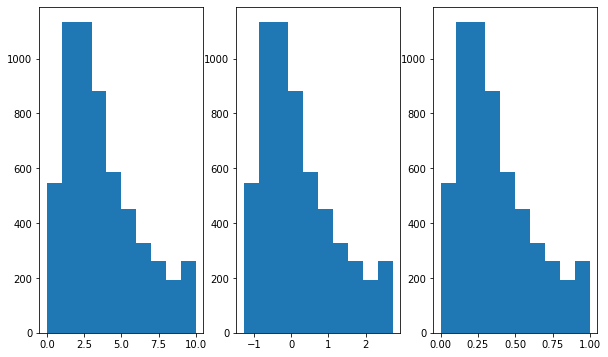

In [ ]:
plt.subplot(1,3,1)
plt.hist(datarain['ปริมาณเมฆ'])
plt.subplot(1,3,2)
plt.hist(datarain_s[:,7])
plt.subplot(1,3,3)
plt.hist(datarain_norm[:,7]);

- การกระจายของค่าก่อนและหลังการทำ Standardize, MinMaxscalar
พบการแจกแจงแบบเบ้ขวาและหลังจากการทำให้ Standardize  
- ข้อมูลกราฟที่ 2 ปริมาณเมฆ หลังทำ Standardize จะพบข้อมูลส่วนมากอยู่ในช่วง -1 ถึง 0  = มีค่าเบี่ยงเบนมาตรฐานต่ำกว่าค่าเฉลี่ยของการกระจาย 
- ข้อมูลกราฟที่ 3 ปริมาณเมฆ หลังทำ MinMaxscalar จะพบข้อมูลส่วนมากอยู่ในช่วง 0.25  หมายถึง ตำแหน่งสัมพัทธ์ของแต่ละค่าข้อมูลค่อนข้างเล็ก

##Create ตารางตามโจทย์

In [ ]:
datarain = datarain[['ความเร็วลม', 'ความกด', 'อุณหภูมิตุ้ม', 'อุณหภูมิจุดน้ำค้าง',
       'อุณหภูมิจุดต่ำสุด', 'ความชื้น','อุณหภูมิต่ำสุด','ปริมาณฝน','ปริมาณเมฆ']]

In [ ]:
datarain['ปริมาณเมฆ'] = datarain['ปริมาณเมฆ'].shift(-1)
datarain

,ความเร็วลม,ความกด,อุณหภูมิตุ้ม,อุณหภูมิจุดน้ำค้าง,อุณหภูมิจุดต่ำสุด,ความชื้น,อุณหภูมิต่ำสุด,ปริมาณฝน,ปริมาณเมฆ
0,3.0,3.0,9.0,9.0,24.2,83,24.2,1.4,10.0
1,2.0,2.0,10.0,10.0,24.0,92,24.0,17.7,10.0
2,3.0,3.0,10.0,10.0,22.9,86,22.9,3.0,8.0
3,2.0,2.0,8.0,8.0,21.9,80,21.9,0.0,10.0
4,2.0,2.0,10.0,10.0,21.7,86,21.7,2.2,10.0
...,...,...,...,...,...,...,...,...,...
5773,2.0,2.0,0.0,0.0,18.4,69,18.4,0.0,0.0
5774,2.0,2.0,0.0,0.0,17.3,61,17.3,0.0,0.0
5775,1.0,1.0,0.0,0.0,13.0,55,13.0,0.0,2.0
5776,2.0,2.0,2.0,2.0,13.8,56,13.8,0.0,1.0
